In [7]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

from micrograd import Value
from nn import MLP

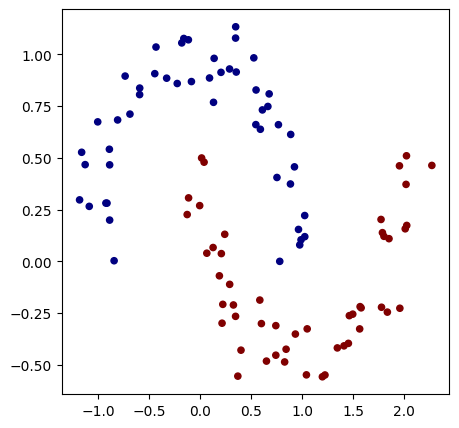

In [8]:
# make up a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")

In [9]:
# init the MLP model

model = MLP(2, [16, 16, 1])
print(model, "number of params", len(model.parameters()))

<nn.MLP object at 0x11639bc50> number of params 337


In [10]:
# loss function
def loss():
    Xb, yb = X, y

    inputs = [list(map(Value, xrow)) for xrow in Xb]

    scores = [model(x) for x in inputs]

    losses = [(1 + (-yi * scorei)).relu() for scorei, yi in zip(scores, yb)]

    data_loss = sum(losses) * (1.0 / len(losses))

    alpha = 1e-4
    reg_loss = sum((p * p for p in model.parameters())) * alpha

    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for scorei, yi in zip(scores, yb)]

    return total_loss, sum(accuracy) / len(accuracy)

In [11]:
# optimisation
for k in range(100):
    total_loss, acc = loss()

    model.zero_grad()

    total_loss.backward()

    learning_rate = 1.0 - 0.9 * k / 100

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    print(f"step {k} loss {total_loss.data}, accuracy {acc * 100}%")

step 0 loss 1.23877644765583, accuracy 34.0%
step 1 loss 1.0012483714886116, accuracy 50.0%
step 2 loss 0.9767460878035654, accuracy 50.0%
step 3 loss 0.5544986188534814, accuracy 74.0%
step 4 loss 0.5160909515354152, accuracy 74.0%
step 5 loss 0.35315659197853155, accuracy 83.0%
step 6 loss 0.2954487582892271, accuracy 87.0%
step 7 loss 0.27234046629513065, accuracy 88.0%
step 8 loss 0.26322254728392697, accuracy 89.0%
step 9 loss 0.2593119752019391, accuracy 88.0%
step 10 loss 0.2569669675793839, accuracy 89.0%
step 11 loss 0.25574263000303654, accuracy 88.0%
step 12 loss 0.23620071719631075, accuracy 89.0%
step 13 loss 0.22664912948026117, accuracy 91.0%
step 14 loss 0.22415970954081582, accuracy 90.0%
step 15 loss 0.22177289086130877, accuracy 91.0%
step 16 loss 0.22249854194051008, accuracy 89.0%
step 17 loss 0.21534670855750201, accuracy 91.0%
step 18 loss 0.21487713700840544, accuracy 90.0%
step 19 loss 0.21206549173108785, accuracy 92.0%
step 20 loss 0.21546727671116728, accura

(-1.5577866174418102, 1.9422133825581898)

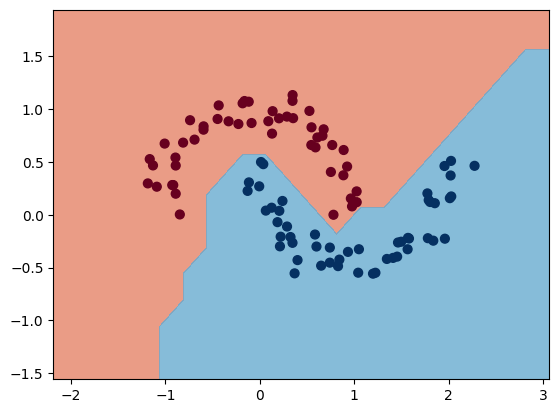

In [15]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())